## Notebook de Entrega: Agente Connect-4
### Equipo: Diego Suárez y John Rojas
### Curso: Fundamentos de Inteligencia Artificial 
### Fecha: Noviembre 2025

##  Bloque 1: Imports y Simulador

In [3]:
import sys
import os

# Agregamos la carpeta superior (PROYECTO-FINAL) a la ruta de búsqueda de Python
sys.path.append(os.path.abspath('..'))

# Ahora sí funcionará el import
from Policy import MCTSAgent
from connect4.policy import Policy # Importamos la clase base también por si acaso

import matplotlib.pyplot as plt
import numpy as np
import time
import random
from copy import deepcopy

# Importamos tu política final
from Policy import MCTSAgent

# --- Configuración de Gráficas ---
plt.style.use('ggplot')

# --- Simulador de Connect-4 para el Notebook ---
# (Usamos una versión ligera para no depender de archivos externos)
class Arena:
    def __init__(self, agent_1, agent_2):
        self.agents = {1: agent_1, -1: agent_2}
        self.board = np.zeros((6, 7), dtype=int)

    def check_winner(self, board, player):
        # Check horizontal, vertical, diagonal
        for r in range(6):
            for c in range(4):
                if np.all(board[r, c:c+4] == player): return True
        for r in range(3):
            for c in range(7):
                if np.all(board[r:r+4, c] == player): return True
        for r in range(3):
            for c in range(4):
                if np.all(board[r:r+4, c:c+4].diagonal() == player): return True
                if np.all(np.fliplr(board[r:r+4, c:c+4]).diagonal() == player): return True
        return False

    def play_game(self, verbose=False):
        self.board = np.zeros((6, 7), dtype=int)
        turn = 1 # 1 starts (Red), -1 follows (Yellow)
        moves = 0
        
        # Mount agents
        self.agents[1].mount()
        self.agents[-1].mount()

        while moves < 42:
            # Get action
            current_agent = self.agents[turn]
            
            # Adaptamos la llamada según la interfaz del agente
            try:
                action = current_agent.get_action(self.board.copy())
            except:
                action = current_agent.act(self.board.copy())

            # Validar jugada
            if self.board[0, action] != 0:
                return -turn # Jugada ilegal pierde

            # Aplicar jugada (gravedad)
            for r in range(5, -1, -1):
                if self.board[r, action] == 0:
                    self.board[r, action] = turn
                    break
            
            # Chequear victoria
            if self.check_winner(self.board, turn):
                return turn
            
            turn *= -1
            moves += 1
            
        return 0 # Empate

# --- Agente Aleatorio para Validación ---
class RandomAgent:
    def mount(self, *args): pass
    def get_action(self, board):
        valid = [c for c in range(7) if board[0,c] == 0]
        return random.choice(valid)
    def act(self, board): return self.get_action(board)

print("Entorno de evaluación listo.")

Entorno de evaluación listo.


##  Bloque 2: Validación del Agente

Ejecutando 50 partidas de validación...
Progreso: 50/50 | Win Rate: 100.0%

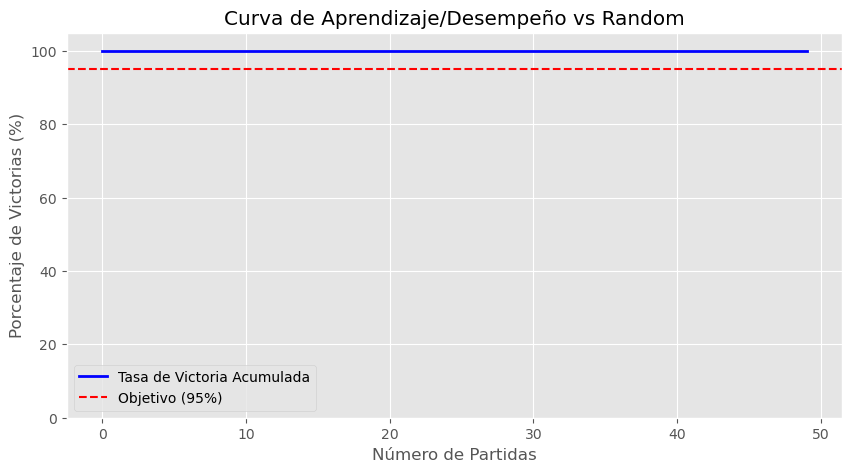


Resultados Finales: {'Wins': 50, 'Losses': 0, 'Draws': 0}


In [4]:
# --- EXPERIMENTO 1: Validación vs Random ---
# Objetivo: Demostrar que el agente supera el 95% de victorias requerido.

NUM_GAMES = 50 # Número de partidas para la gráfica
my_agent = MCTSAgent()
random_agent = RandomAgent()

results = {'Wins': 0, 'Losses': 0, 'Draws': 0}
history = []

print(f"Ejecutando {NUM_GAMES} partidas de validación...")

for i in range(NUM_GAMES):
    # Alternar quién empieza para ser justos
    if i % 2 == 0:
        arena = Arena(my_agent, random_agent) # Soy 1 (Rojo)
        res = arena.play_game()
        if res == 1: results['Wins'] += 1
        elif res == -1: results['Losses'] += 1
        else: results['Draws'] += 1
    else:
        arena = Arena(random_agent, my_agent) # Soy -1 (Amarillo)
        res = arena.play_game()
        if res == -1: results['Wins'] += 1
        elif res == 1: results['Losses'] += 1
        else: results['Draws'] += 1
    
    # Guardar win rate acumulado para la gráfica
    current_wr = (results['Wins'] / (i + 1)) * 100
    history.append(current_wr)
    print(f"\rProgreso: {i+1}/{NUM_GAMES} | Win Rate: {current_wr:.1f}%", end="")

# --- Visualización ---
plt.figure(figsize=(10, 5))
plt.plot(history, label='Tasa de Victoria Acumulada', color='blue', linewidth=2)
plt.axhline(y=95, color='red', linestyle='--', label='Objetivo (95%)')
plt.title('Curva de Aprendizaje/Desempeño vs Random')
plt.xlabel('Número de Partidas')
plt.ylabel('Porcentaje de Victorias (%)')
plt.legend()
plt.ylim(0, 105)
plt.show()

print(f"\nResultados Finales: {results}")

## Bloque 3: Optimización

Comparando Estrategias: Híbrido vs Básico (20 partidas)...
Partida 20/20...

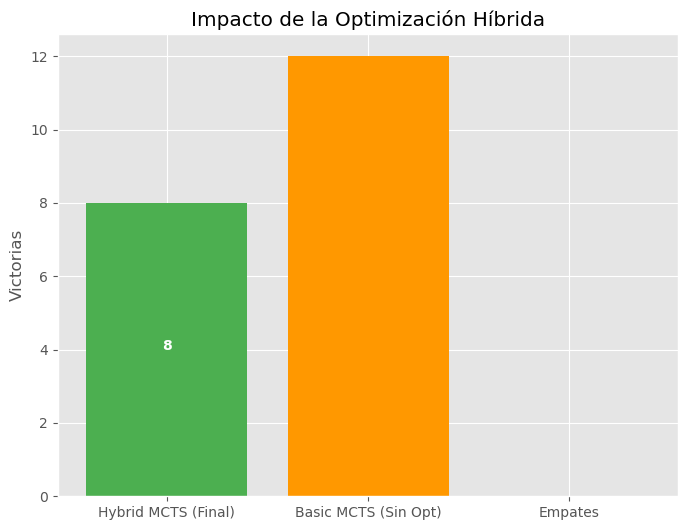


El agente Híbrido ganó el 40.0% de las partidas.


In [5]:
# --- EXPERIMENTO 2: Ablation Study (Optimización) ---
# Objetivo: Demostrar que la estrategia "Híbrida" es mejor que un MCTS estándar.

# 1. Definimos una versión "Degradada" (MCTS Básico sin tu heurística)
class BasicMCTSAgent(MCTSAgent):
    # Sobrescribimos tu simulación inteligente con una tonta (random puro)
    def _simulate_hybrid(self, state):
        curr = state.clone()
        depth = 0
        while not curr.is_terminal() and depth < 30:
            valid = curr.get_valid_moves()
            if not valid: break
            # Random puro, sin inteligencia
            curr.make_move(random.choice(valid))
            depth += 1
        return curr

# 2. Competencia: Tu Agente Final vs. Tu Agente Básico
# Si tu optimización funciona, deberías ganar la mayoría.
hybrid_agent = MCTSAgent()      # Tu código final
basic_agent = BasicMCTSAgent()  # Versión sin optimización

matches = 20
wins_hybrid = 0
wins_basic = 0
draws = 0

print(f"Comparando Estrategias: Híbrido vs Básico ({matches} partidas)...")

for i in range(matches):
    # Alternar inicio
    if i % 2 == 0:
        arena = Arena(hybrid_agent, basic_agent)
        res = arena.play_game()
        if res == 1: wins_hybrid += 1
        elif res == -1: wins_basic += 1
        else: draws += 1
    else:
        arena = Arena(basic_agent, hybrid_agent)
        res = arena.play_game()
        if res == -1: wins_hybrid += 1
        elif res == 1: wins_basic += 1
        else: draws += 1
    print(f"\rPartida {i+1}/{matches}...", end="")

# --- Visualización Comparativa ---
labels = ['Hybrid MCTS (Final)', 'Basic MCTS (Sin Opt)', 'Empates']
values = [wins_hybrid, wins_basic, draws]
colors = ['#4CAF50', '#FF9800', '#9E9E9E']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=colors)
plt.title('Impacto de la Optimización Híbrida')
plt.ylabel('Victorias')
plt.text(0, wins_hybrid/2, f"{wins_hybrid}", ha='center', color='white', fontweight='bold')
plt.show()

print(f"\nEl agente Híbrido ganó el {wins_hybrid/matches*100:.1f}% de las partidas.")

## Bloque 4: Análisis de Tiempo


Midiendo tiempos de respuesta...


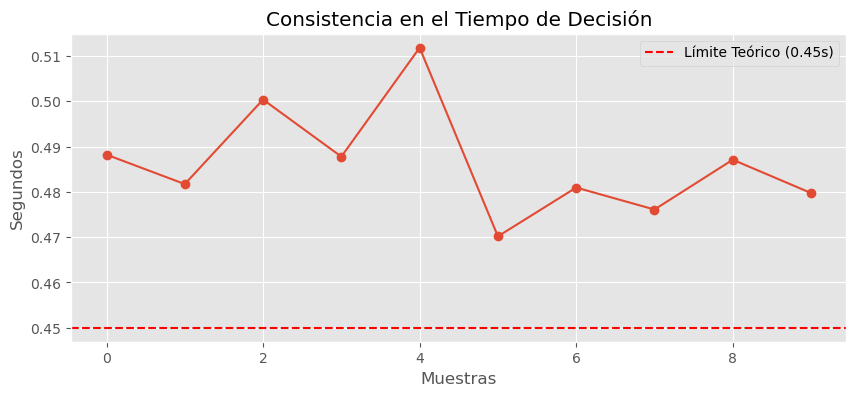

Tiempo Promedio: 0.4864s
Tiempo Máximo: 0.5119s


In [6]:
# --- EXPERIMENTO 3: Gestión de Tiempo ---
# Objetivo: Verificar que el agente usa el presupuesto de 0.45s eficientemente.

test_agent = MCTSAgent()
fake_board = np.zeros((6, 7), dtype=int)
# Ponemos algunas fichas para que no sea el inicio
fake_board[5, 3] = 1
fake_board[5, 2] = -1

times = []
print("Midiendo tiempos de respuesta...")

for _ in range(10):
    start = time.time()
    test_agent.get_action(fake_board.copy())
    end = time.time()
    times.append(end - start)

avg_time = sum(times) / len(times)
max_time = max(times)

plt.figure(figsize=(10, 4))
plt.plot(times, marker='o', linestyle='-')
plt.axhline(y=0.45, color='r', linestyle='--', label='Límite Teórico (0.45s)')
plt.title('Consistencia en el Tiempo de Decisión')
plt.ylabel('Segundos')
plt.xlabel('Muestras')
plt.legend()
plt.show()

print(f"Tiempo Promedio: {avg_time:.4f}s")
print(f"Tiempo Máximo: {max_time:.4f}s")